# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


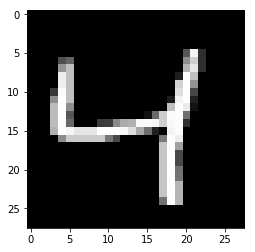

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [4]:
image_size = mnist.train.images.reshape(-1,28,28)
image_size.shape

(60000, 28, 28)

In [11]:
learning_rate = 0.001
# Input and target placeholders
image_size = mnist.train.images.reshape(-1,28,28, 1)

inputs_ = tf.placeholder(tf.float32,(None,28,28,1))
targets_ = tf.placeholder(tf.float32,(None,28,28,1))

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), activation=tf.nn.relu, padding='same')
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), strides=(2,2))
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), activation=tf.nn.relu, padding='same')
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), strides=(2,2))
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), activation=tf.nn.relu, padding='same')
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), strides=(2,2))
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, size=(7,7) )
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, size=(14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, size=(28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(upsample3, 1, (1,1), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [12]:
sess = tf.Session()

In [ ]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.7148
Epoch: 1/20... Training loss: 0.7069
Epoch: 1/20... Training loss: 0.7017
Epoch: 1/20... Training loss: 0.6976
Epoch: 1/20... Training loss: 0.6945
Epoch: 1/20... Training loss: 0.6920
Epoch: 1/20... Training loss: 0.6898
Epoch: 1/20... Training loss: 0.6882
Epoch: 1/20... Training loss: 0.6866
Epoch: 1/20... Training loss: 0.6854
Epoch: 1/20... Training loss: 0.6843
Epoch: 1/20... Training loss: 0.6830
Epoch: 1/20... Training loss: 0.6817
Epoch: 1/20... Training loss: 0.6801
Epoch: 1/20... Training loss: 0.6787
Epoch: 1/20... Training loss: 0.6769
Epoch: 1/20... Training loss: 0.6751
Epoch: 1/20... Training loss: 0.6727
Epoch: 1/20... Training loss: 0.6709
Epoch: 1/20... Training loss: 0.6684
Epoch: 1/20... Training loss: 0.6649
Epoch: 1/20... Training loss: 0.6617
Epoch: 1/20... Training loss: 0.6575
Epoch: 1/20... Training loss: 0.6532
Epoch: 1/20... Training loss: 0.6481
Epoch: 1/20... Training loss: 0.6416
Epoch: 1/20... Training loss: 0.6341
E

Epoch: 1/20... Training loss: 0.2011
Epoch: 1/20... Training loss: 0.2062
Epoch: 1/20... Training loss: 0.2119
Epoch: 1/20... Training loss: 0.2100
Epoch: 1/20... Training loss: 0.2128
Epoch: 1/20... Training loss: 0.2050
Epoch: 1/20... Training loss: 0.2067
Epoch: 1/20... Training loss: 0.2056
Epoch: 1/20... Training loss: 0.2025
Epoch: 1/20... Training loss: 0.2101
Epoch: 1/20... Training loss: 0.2017
Epoch: 1/20... Training loss: 0.2009
Epoch: 1/20... Training loss: 0.2022
Epoch: 1/20... Training loss: 0.2018
Epoch: 1/20... Training loss: 0.1988
Epoch: 1/20... Training loss: 0.2121
Epoch: 1/20... Training loss: 0.2092
Epoch: 1/20... Training loss: 0.2033
Epoch: 1/20... Training loss: 0.2054
Epoch: 1/20... Training loss: 0.1915
Epoch: 1/20... Training loss: 0.2028
Epoch: 1/20... Training loss: 0.2029
Epoch: 1/20... Training loss: 0.1945
Epoch: 1/20... Training loss: 0.2060
Epoch: 1/20... Training loss: 0.1991
Epoch: 1/20... Training loss: 0.2063
Epoch: 1/20... Training loss: 0.1943
E

Epoch: 2/20... Training loss: 0.1860
Epoch: 2/20... Training loss: 0.1860
Epoch: 2/20... Training loss: 0.1857
Epoch: 2/20... Training loss: 0.1916
Epoch: 2/20... Training loss: 0.1816
Epoch: 2/20... Training loss: 0.1804
Epoch: 2/20... Training loss: 0.1776
Epoch: 2/20... Training loss: 0.1867
Epoch: 2/20... Training loss: 0.1830
Epoch: 2/20... Training loss: 0.1876
Epoch: 2/20... Training loss: 0.1848
Epoch: 2/20... Training loss: 0.1869
Epoch: 2/20... Training loss: 0.1858
Epoch: 2/20... Training loss: 0.1791
Epoch: 2/20... Training loss: 0.1890
Epoch: 2/20... Training loss: 0.1861
Epoch: 2/20... Training loss: 0.1857
Epoch: 2/20... Training loss: 0.1836
Epoch: 2/20... Training loss: 0.1856
Epoch: 2/20... Training loss: 0.1808
Epoch: 2/20... Training loss: 0.1885
Epoch: 2/20... Training loss: 0.1863
Epoch: 2/20... Training loss: 0.1837
Epoch: 2/20... Training loss: 0.1855
Epoch: 2/20... Training loss: 0.1853
Epoch: 2/20... Training loss: 0.1845
Epoch: 2/20... Training loss: 0.1809
E

Epoch: 3/20... Training loss: 0.1721
Epoch: 3/20... Training loss: 0.1698
Epoch: 3/20... Training loss: 0.1721
Epoch: 3/20... Training loss: 0.1737
Epoch: 3/20... Training loss: 0.1758
Epoch: 3/20... Training loss: 0.1723
Epoch: 3/20... Training loss: 0.1725
Epoch: 3/20... Training loss: 0.1753
Epoch: 3/20... Training loss: 0.1731
Epoch: 3/20... Training loss: 0.1749
Epoch: 3/20... Training loss: 0.1745
Epoch: 3/20... Training loss: 0.1740
Epoch: 3/20... Training loss: 0.1750
Epoch: 3/20... Training loss: 0.1797
Epoch: 3/20... Training loss: 0.1735
Epoch: 3/20... Training loss: 0.1791
Epoch: 3/20... Training loss: 0.1766
Epoch: 3/20... Training loss: 0.1727
Epoch: 3/20... Training loss: 0.1742
Epoch: 3/20... Training loss: 0.1724
Epoch: 3/20... Training loss: 0.1760
Epoch: 3/20... Training loss: 0.1726
Epoch: 3/20... Training loss: 0.1717
Epoch: 3/20... Training loss: 0.1667
Epoch: 3/20... Training loss: 0.1726
Epoch: 3/20... Training loss: 0.1753
Epoch: 3/20... Training loss: 0.1728
E

Epoch: 3/20... Training loss: 0.1675
Epoch: 3/20... Training loss: 0.1750
Epoch: 3/20... Training loss: 0.1696
Epoch: 3/20... Training loss: 0.1598
Epoch: 3/20... Training loss: 0.1642
Epoch: 3/20... Training loss: 0.1611
Epoch: 3/20... Training loss: 0.1639
Epoch: 3/20... Training loss: 0.1613
Epoch: 3/20... Training loss: 0.1616
Epoch: 3/20... Training loss: 0.1629
Epoch: 3/20... Training loss: 0.1692
Epoch: 3/20... Training loss: 0.1661
Epoch: 4/20... Training loss: 0.1619
Epoch: 4/20... Training loss: 0.1724
Epoch: 4/20... Training loss: 0.1674
Epoch: 4/20... Training loss: 0.1639
Epoch: 4/20... Training loss: 0.1649
Epoch: 4/20... Training loss: 0.1648
Epoch: 4/20... Training loss: 0.1638
Epoch: 4/20... Training loss: 0.1717
Epoch: 4/20... Training loss: 0.1704
Epoch: 4/20... Training loss: 0.1627
Epoch: 4/20... Training loss: 0.1694
Epoch: 4/20... Training loss: 0.1672
Epoch: 4/20... Training loss: 0.1669
Epoch: 4/20... Training loss: 0.1645
Epoch: 4/20... Training loss: 0.1655
E

Epoch: 4/20... Training loss: 0.1592
Epoch: 4/20... Training loss: 0.1621
Epoch: 4/20... Training loss: 0.1622
Epoch: 4/20... Training loss: 0.1652
Epoch: 4/20... Training loss: 0.1559
Epoch: 4/20... Training loss: 0.1602
Epoch: 4/20... Training loss: 0.1597
Epoch: 4/20... Training loss: 0.1623
Epoch: 4/20... Training loss: 0.1606
Epoch: 4/20... Training loss: 0.1618
Epoch: 4/20... Training loss: 0.1614
Epoch: 4/20... Training loss: 0.1621
Epoch: 4/20... Training loss: 0.1592
Epoch: 4/20... Training loss: 0.1609
Epoch: 4/20... Training loss: 0.1611
Epoch: 4/20... Training loss: 0.1555
Epoch: 4/20... Training loss: 0.1565
Epoch: 4/20... Training loss: 0.1624
Epoch: 4/20... Training loss: 0.1640
Epoch: 4/20... Training loss: 0.1631
Epoch: 4/20... Training loss: 0.1654
Epoch: 4/20... Training loss: 0.1560
Epoch: 4/20... Training loss: 0.1580
Epoch: 4/20... Training loss: 0.1616
Epoch: 4/20... Training loss: 0.1582
Epoch: 4/20... Training loss: 0.1628
Epoch: 4/20... Training loss: 0.1631
E

Epoch: 5/20... Training loss: 0.1631
Epoch: 5/20... Training loss: 0.1622
Epoch: 5/20... Training loss: 0.1574
Epoch: 5/20... Training loss: 0.1546
Epoch: 5/20... Training loss: 0.1563
Epoch: 5/20... Training loss: 0.1586
Epoch: 5/20... Training loss: 0.1609
Epoch: 5/20... Training loss: 0.1549
Epoch: 5/20... Training loss: 0.1668
Epoch: 5/20... Training loss: 0.1615
Epoch: 5/20... Training loss: 0.1539
Epoch: 5/20... Training loss: 0.1594
Epoch: 5/20... Training loss: 0.1662
Epoch: 5/20... Training loss: 0.1594
Epoch: 5/20... Training loss: 0.1565
Epoch: 5/20... Training loss: 0.1581
Epoch: 5/20... Training loss: 0.1586
Epoch: 5/20... Training loss: 0.1633
Epoch: 5/20... Training loss: 0.1589
Epoch: 5/20... Training loss: 0.1593
Epoch: 5/20... Training loss: 0.1636
Epoch: 5/20... Training loss: 0.1567
Epoch: 5/20... Training loss: 0.1584
Epoch: 5/20... Training loss: 0.1557
Epoch: 5/20... Training loss: 0.1576
Epoch: 5/20... Training loss: 0.1577
Epoch: 5/20... Training loss: 0.1606
E

Epoch: 6/20... Training loss: 0.1559
Epoch: 6/20... Training loss: 0.1566
Epoch: 6/20... Training loss: 0.1559
Epoch: 6/20... Training loss: 0.1582
Epoch: 6/20... Training loss: 0.1585
Epoch: 6/20... Training loss: 0.1563
Epoch: 6/20... Training loss: 0.1603
Epoch: 6/20... Training loss: 0.1569
Epoch: 6/20... Training loss: 0.1539
Epoch: 6/20... Training loss: 0.1583
Epoch: 6/20... Training loss: 0.1553
Epoch: 6/20... Training loss: 0.1609
Epoch: 6/20... Training loss: 0.1572
Epoch: 6/20... Training loss: 0.1525
Epoch: 6/20... Training loss: 0.1579
Epoch: 6/20... Training loss: 0.1504
Epoch: 6/20... Training loss: 0.1571
Epoch: 6/20... Training loss: 0.1597
Epoch: 6/20... Training loss: 0.1555
Epoch: 6/20... Training loss: 0.1586
Epoch: 6/20... Training loss: 0.1541
Epoch: 6/20... Training loss: 0.1637
Epoch: 6/20... Training loss: 0.1562
Epoch: 6/20... Training loss: 0.1599
Epoch: 6/20... Training loss: 0.1542
Epoch: 6/20... Training loss: 0.1549
Epoch: 6/20... Training loss: 0.1527
E

Epoch: 6/20... Training loss: 0.1564
Epoch: 6/20... Training loss: 0.1549
Epoch: 6/20... Training loss: 0.1517
Epoch: 6/20... Training loss: 0.1517
Epoch: 6/20... Training loss: 0.1559
Epoch: 6/20... Training loss: 0.1568
Epoch: 6/20... Training loss: 0.1573
Epoch: 6/20... Training loss: 0.1567
Epoch: 6/20... Training loss: 0.1582
Epoch: 6/20... Training loss: 0.1552
Epoch: 6/20... Training loss: 0.1541
Epoch: 6/20... Training loss: 0.1565
Epoch: 6/20... Training loss: 0.1559
Epoch: 6/20... Training loss: 0.1558
Epoch: 6/20... Training loss: 0.1544
Epoch: 6/20... Training loss: 0.1532
Epoch: 6/20... Training loss: 0.1543
Epoch: 6/20... Training loss: 0.1509
Epoch: 6/20... Training loss: 0.1524
Epoch: 6/20... Training loss: 0.1510
Epoch: 6/20... Training loss: 0.1552
Epoch: 6/20... Training loss: 0.1513
Epoch: 6/20... Training loss: 0.1540
Epoch: 6/20... Training loss: 0.1554
Epoch: 7/20... Training loss: 0.1521
Epoch: 7/20... Training loss: 0.1533
Epoch: 7/20... Training loss: 0.1593
E

Epoch: 7/20... Training loss: 0.1570
Epoch: 7/20... Training loss: 0.1557
Epoch: 7/20... Training loss: 0.1528
Epoch: 7/20... Training loss: 0.1520
Epoch: 7/20... Training loss: 0.1573
Epoch: 7/20... Training loss: 0.1527
Epoch: 7/20... Training loss: 0.1544
Epoch: 7/20... Training loss: 0.1494
Epoch: 7/20... Training loss: 0.1530
Epoch: 7/20... Training loss: 0.1551
Epoch: 7/20... Training loss: 0.1563
Epoch: 7/20... Training loss: 0.1593
Epoch: 7/20... Training loss: 0.1540
Epoch: 7/20... Training loss: 0.1537
Epoch: 7/20... Training loss: 0.1495
Epoch: 7/20... Training loss: 0.1607
Epoch: 7/20... Training loss: 0.1481
Epoch: 7/20... Training loss: 0.1453
Epoch: 7/20... Training loss: 0.1537
Epoch: 7/20... Training loss: 0.1520
Epoch: 7/20... Training loss: 0.1549
Epoch: 7/20... Training loss: 0.1507
Epoch: 7/20... Training loss: 0.1541
Epoch: 7/20... Training loss: 0.1533
Epoch: 7/20... Training loss: 0.1501
Epoch: 7/20... Training loss: 0.1538
Epoch: 7/20... Training loss: 0.1502
E

Epoch: 8/20... Training loss: 0.1520
Epoch: 8/20... Training loss: 0.1517
Epoch: 8/20... Training loss: 0.1493
Epoch: 8/20... Training loss: 0.1518
Epoch: 8/20... Training loss: 0.1541
Epoch: 8/20... Training loss: 0.1524
Epoch: 8/20... Training loss: 0.1541
Epoch: 8/20... Training loss: 0.1551
Epoch: 8/20... Training loss: 0.1561
Epoch: 8/20... Training loss: 0.1552
Epoch: 8/20... Training loss: 0.1500
Epoch: 8/20... Training loss: 0.1555
Epoch: 8/20... Training loss: 0.1543
Epoch: 8/20... Training loss: 0.1531
Epoch: 8/20... Training loss: 0.1531
Epoch: 8/20... Training loss: 0.1534
Epoch: 8/20... Training loss: 0.1511
Epoch: 8/20... Training loss: 0.1541
Epoch: 8/20... Training loss: 0.1557
Epoch: 8/20... Training loss: 0.1518
Epoch: 8/20... Training loss: 0.1466
Epoch: 8/20... Training loss: 0.1518
Epoch: 8/20... Training loss: 0.1507
Epoch: 8/20... Training loss: 0.1569
Epoch: 8/20... Training loss: 0.1499
Epoch: 8/20... Training loss: 0.1496
Epoch: 8/20... Training loss: 0.1568
E

Epoch: 9/20... Training loss: 0.1529
Epoch: 9/20... Training loss: 0.1471
Epoch: 9/20... Training loss: 0.1540
Epoch: 9/20... Training loss: 0.1492
Epoch: 9/20... Training loss: 0.1465
Epoch: 9/20... Training loss: 0.1551
Epoch: 9/20... Training loss: 0.1511
Epoch: 9/20... Training loss: 0.1525
Epoch: 9/20... Training loss: 0.1535
Epoch: 9/20... Training loss: 0.1488
Epoch: 9/20... Training loss: 0.1468
Epoch: 9/20... Training loss: 0.1507
Epoch: 9/20... Training loss: 0.1513
Epoch: 9/20... Training loss: 0.1518
Epoch: 9/20... Training loss: 0.1495
Epoch: 9/20... Training loss: 0.1519
Epoch: 9/20... Training loss: 0.1503
Epoch: 9/20... Training loss: 0.1512
Epoch: 9/20... Training loss: 0.1531
Epoch: 9/20... Training loss: 0.1553
Epoch: 9/20... Training loss: 0.1487
Epoch: 9/20... Training loss: 0.1507
Epoch: 9/20... Training loss: 0.1534
Epoch: 9/20... Training loss: 0.1517
Epoch: 9/20... Training loss: 0.1556
Epoch: 9/20... Training loss: 0.1548
Epoch: 9/20... Training loss: 0.1490
E

Epoch: 9/20... Training loss: 0.1541
Epoch: 9/20... Training loss: 0.1478
Epoch: 9/20... Training loss: 0.1465
Epoch: 9/20... Training loss: 0.1484
Epoch: 9/20... Training loss: 0.1450
Epoch: 9/20... Training loss: 0.1497
Epoch: 9/20... Training loss: 0.1459
Epoch: 9/20... Training loss: 0.1509
Epoch: 9/20... Training loss: 0.1522
Epoch: 9/20... Training loss: 0.1467
Epoch: 9/20... Training loss: 0.1545
Epoch: 9/20... Training loss: 0.1492
Epoch: 9/20... Training loss: 0.1480
Epoch: 9/20... Training loss: 0.1483
Epoch: 9/20... Training loss: 0.1467
Epoch: 9/20... Training loss: 0.1545
Epoch: 9/20... Training loss: 0.1485
Epoch: 9/20... Training loss: 0.1540
Epoch: 9/20... Training loss: 0.1513
Epoch: 9/20... Training loss: 0.1485
Epoch: 9/20... Training loss: 0.1529
Epoch: 9/20... Training loss: 0.1491
Epoch: 9/20... Training loss: 0.1528
Epoch: 9/20... Training loss: 0.1530
Epoch: 9/20... Training loss: 0.1440
Epoch: 9/20... Training loss: 0.1492
Epoch: 9/20... Training loss: 0.1516
E

Epoch: 10/20... Training loss: 0.1484
Epoch: 10/20... Training loss: 0.1493
Epoch: 10/20... Training loss: 0.1491
Epoch: 10/20... Training loss: 0.1471
Epoch: 10/20... Training loss: 0.1447
Epoch: 10/20... Training loss: 0.1494
Epoch: 10/20... Training loss: 0.1478
Epoch: 10/20... Training loss: 0.1527
Epoch: 10/20... Training loss: 0.1495
Epoch: 10/20... Training loss: 0.1532
Epoch: 10/20... Training loss: 0.1452
Epoch: 10/20... Training loss: 0.1522
Epoch: 10/20... Training loss: 0.1481
Epoch: 10/20... Training loss: 0.1492
Epoch: 10/20... Training loss: 0.1448
Epoch: 10/20... Training loss: 0.1508
Epoch: 10/20... Training loss: 0.1448
Epoch: 10/20... Training loss: 0.1540
Epoch: 10/20... Training loss: 0.1534
Epoch: 10/20... Training loss: 0.1464
Epoch: 10/20... Training loss: 0.1513
Epoch: 10/20... Training loss: 0.1467
Epoch: 10/20... Training loss: 0.1468
Epoch: 10/20... Training loss: 0.1499
Epoch: 10/20... Training loss: 0.1465
Epoch: 10/20... Training loss: 0.1463
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1526
Epoch: 11/20... Training loss: 0.1477
Epoch: 11/20... Training loss: 0.1441
Epoch: 11/20... Training loss: 0.1439
Epoch: 11/20... Training loss: 0.1467
Epoch: 11/20... Training loss: 0.1438
Epoch: 11/20... Training loss: 0.1507
Epoch: 11/20... Training loss: 0.1455
Epoch: 11/20... Training loss: 0.1453
Epoch: 11/20... Training loss: 0.1469
Epoch: 11/20... Training loss: 0.1483
Epoch: 11/20... Training loss: 0.1441
Epoch: 11/20... Training loss: 0.1460
Epoch: 11/20... Training loss: 0.1475
Epoch: 11/20... Training loss: 0.1499
Epoch: 11/20... Training loss: 0.1484
Epoch: 11/20... Training loss: 0.1452
Epoch: 11/20... Training loss: 0.1486
Epoch: 11/20... Training loss: 0.1423
Epoch: 11/20... Training loss: 0.1451
Epoch: 11/20... Training loss: 0.1486
Epoch: 11/20... Training loss: 0.1536
Epoch: 11/20... Training loss: 0.1476
Epoch: 11/20... Training loss: 0.1492
Epoch: 11/20... Training loss: 0.1443
Epoch: 11/20... Training loss: 0.1499
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1497
Epoch: 12/20... Training loss: 0.1509
Epoch: 12/20... Training loss: 0.1466
Epoch: 12/20... Training loss: 0.1526
Epoch: 12/20... Training loss: 0.1453
Epoch: 12/20... Training loss: 0.1449
Epoch: 12/20... Training loss: 0.1456
Epoch: 12/20... Training loss: 0.1557
Epoch: 12/20... Training loss: 0.1485
Epoch: 12/20... Training loss: 0.1412
Epoch: 12/20... Training loss: 0.1470
Epoch: 12/20... Training loss: 0.1460
Epoch: 12/20... Training loss: 0.1457
Epoch: 12/20... Training loss: 0.1433
Epoch: 12/20... Training loss: 0.1497
Epoch: 12/20... Training loss: 0.1437
Epoch: 12/20... Training loss: 0.1462
Epoch: 12/20... Training loss: 0.1466
Epoch: 12/20... Training loss: 0.1465
Epoch: 12/20... Training loss: 0.1477
Epoch: 12/20... Training loss: 0.1486
Epoch: 12/20... Training loss: 0.1482
Epoch: 12/20... Training loss: 0.1546
Epoch: 12/20... Training loss: 0.1474
Epoch: 12/20... Training loss: 0.1502
Epoch: 12/20... Training loss: 0.1482
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1507
Epoch: 12/20... Training loss: 0.1477
Epoch: 12/20... Training loss: 0.1507
Epoch: 12/20... Training loss: 0.1485
Epoch: 12/20... Training loss: 0.1485
Epoch: 12/20... Training loss: 0.1471
Epoch: 12/20... Training loss: 0.1478
Epoch: 12/20... Training loss: 0.1442
Epoch: 12/20... Training loss: 0.1495
Epoch: 12/20... Training loss: 0.1473
Epoch: 12/20... Training loss: 0.1534
Epoch: 12/20... Training loss: 0.1489
Epoch: 12/20... Training loss: 0.1430
Epoch: 12/20... Training loss: 0.1498
Epoch: 12/20... Training loss: 0.1466
Epoch: 12/20... Training loss: 0.1513
Epoch: 12/20... Training loss: 0.1509
Epoch: 12/20... Training loss: 0.1474
Epoch: 12/20... Training loss: 0.1515
Epoch: 12/20... Training loss: 0.1484
Epoch: 12/20... Training loss: 0.1449
Epoch: 12/20... Training loss: 0.1486
Epoch: 12/20... Training loss: 0.1469
Epoch: 12/20... Training loss: 0.1498
Epoch: 12/20... Training loss: 0.1456
Epoch: 12/20... Training loss: 0.1448
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1459
Epoch: 13/20... Training loss: 0.1467
Epoch: 13/20... Training loss: 0.1506
Epoch: 13/20... Training loss: 0.1485
Epoch: 13/20... Training loss: 0.1407
Epoch: 13/20... Training loss: 0.1421
Epoch: 13/20... Training loss: 0.1439
Epoch: 13/20... Training loss: 0.1473
Epoch: 13/20... Training loss: 0.1444
Epoch: 13/20... Training loss: 0.1463
Epoch: 13/20... Training loss: 0.1471
Epoch: 13/20... Training loss: 0.1478
Epoch: 13/20... Training loss: 0.1479
Epoch: 13/20... Training loss: 0.1471
Epoch: 13/20... Training loss: 0.1502
Epoch: 13/20... Training loss: 0.1439
Epoch: 13/20... Training loss: 0.1479
Epoch: 13/20... Training loss: 0.1445
Epoch: 13/20... Training loss: 0.1436
Epoch: 13/20... Training loss: 0.1476
Epoch: 13/20... Training loss: 0.1402
Epoch: 13/20... Training loss: 0.1509
Epoch: 13/20... Training loss: 0.1434
Epoch: 13/20... Training loss: 0.1457
Epoch: 13/20... Training loss: 0.1485
Epoch: 13/20... Training loss: 0.1520
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1456
Epoch: 14/20... Training loss: 0.1479
Epoch: 14/20... Training loss: 0.1443
Epoch: 14/20... Training loss: 0.1496
Epoch: 14/20... Training loss: 0.1481
Epoch: 14/20... Training loss: 0.1498
Epoch: 14/20... Training loss: 0.1448
Epoch: 14/20... Training loss: 0.1437
Epoch: 14/20... Training loss: 0.1456
Epoch: 14/20... Training loss: 0.1477
Epoch: 14/20... Training loss: 0.1436
Epoch: 14/20... Training loss: 0.1481
Epoch: 14/20... Training loss: 0.1471
Epoch: 14/20... Training loss: 0.1485
Epoch: 14/20... Training loss: 0.1420
Epoch: 14/20... Training loss: 0.1459
Epoch: 14/20... Training loss: 0.1434
Epoch: 14/20... Training loss: 0.1465
Epoch: 14/20... Training loss: 0.1471
Epoch: 14/20... Training loss: 0.1460
Epoch: 14/20... Training loss: 0.1495
Epoch: 14/20... Training loss: 0.1446
Epoch: 14/20... Training loss: 0.1492
Epoch: 14/20... Training loss: 0.1441
Epoch: 14/20... Training loss: 0.1485
Epoch: 14/20... Training loss: 0.1448
Epoch: 14/20

Epoch: 14/20... Training loss: 0.1456
Epoch: 14/20... Training loss: 0.1482
Epoch: 14/20... Training loss: 0.1462
Epoch: 14/20... Training loss: 0.1465
Epoch: 14/20... Training loss: 0.1482
Epoch: 14/20... Training loss: 0.1505
Epoch: 14/20... Training loss: 0.1495
Epoch: 14/20... Training loss: 0.1501
Epoch: 14/20... Training loss: 0.1507
Epoch: 14/20... Training loss: 0.1493
Epoch: 14/20... Training loss: 0.1451
Epoch: 14/20... Training loss: 0.1448
Epoch: 14/20... Training loss: 0.1458
Epoch: 14/20... Training loss: 0.1492
Epoch: 14/20... Training loss: 0.1482
Epoch: 14/20... Training loss: 0.1455
Epoch: 14/20... Training loss: 0.1459
Epoch: 14/20... Training loss: 0.1475
Epoch: 14/20... Training loss: 0.1439
Epoch: 14/20... Training loss: 0.1430
Epoch: 14/20... Training loss: 0.1471
Epoch: 14/20... Training loss: 0.1452
Epoch: 15/20... Training loss: 0.1451
Epoch: 15/20... Training loss: 0.1476
Epoch: 15/20... Training loss: 0.1464
Epoch: 15/20... Training loss: 0.1418
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1471
Epoch: 15/20... Training loss: 0.1431
Epoch: 15/20... Training loss: 0.1479
Epoch: 15/20... Training loss: 0.1395
Epoch: 15/20... Training loss: 0.1435
Epoch: 15/20... Training loss: 0.1443
Epoch: 15/20... Training loss: 0.1492
Epoch: 15/20... Training loss: 0.1469
Epoch: 15/20... Training loss: 0.1496
Epoch: 15/20... Training loss: 0.1449
Epoch: 15/20... Training loss: 0.1413
Epoch: 15/20... Training loss: 0.1461
Epoch: 15/20... Training loss: 0.1428
Epoch: 15/20... Training loss: 0.1465
Epoch: 15/20... Training loss: 0.1458
Epoch: 15/20... Training loss: 0.1474
Epoch: 15/20... Training loss: 0.1462
Epoch: 15/20... Training loss: 0.1466
Epoch: 15/20... Training loss: 0.1422
Epoch: 15/20... Training loss: 0.1482
Epoch: 15/20... Training loss: 0.1454
Epoch: 15/20... Training loss: 0.1541
Epoch: 15/20... Training loss: 0.1460
Epoch: 15/20... Training loss: 0.1436
Epoch: 15/20... Training loss: 0.1470
Epoch: 15/20... Training loss: 0.1445
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1481
Epoch: 16/20... Training loss: 0.1420
Epoch: 16/20... Training loss: 0.1479
Epoch: 16/20... Training loss: 0.1464
Epoch: 16/20... Training loss: 0.1435
Epoch: 16/20... Training loss: 0.1485
Epoch: 16/20... Training loss: 0.1429
Epoch: 16/20... Training loss: 0.1468
Epoch: 16/20... Training loss: 0.1460
Epoch: 16/20... Training loss: 0.1489
Epoch: 16/20... Training loss: 0.1433
Epoch: 16/20... Training loss: 0.1398
Epoch: 16/20... Training loss: 0.1427
Epoch: 16/20... Training loss: 0.1427
Epoch: 16/20... Training loss: 0.1456
Epoch: 16/20... Training loss: 0.1450
Epoch: 16/20... Training loss: 0.1481
Epoch: 16/20... Training loss: 0.1423
Epoch: 16/20... Training loss: 0.1478
Epoch: 16/20... Training loss: 0.1469
Epoch: 16/20... Training loss: 0.1425
Epoch: 16/20... Training loss: 0.1445
Epoch: 16/20... Training loss: 0.1489
Epoch: 16/20... Training loss: 0.1426
Epoch: 16/20... Training loss: 0.1449
Epoch: 16/20... Training loss: 0.1458
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1491
Epoch: 17/20... Training loss: 0.1426
Epoch: 17/20... Training loss: 0.1448
Epoch: 17/20... Training loss: 0.1452
Epoch: 17/20... Training loss: 0.1467
Epoch: 17/20... Training loss: 0.1480
Epoch: 17/20... Training loss: 0.1464
Epoch: 17/20... Training loss: 0.1450
Epoch: 17/20... Training loss: 0.1505
Epoch: 17/20... Training loss: 0.1468
Epoch: 17/20... Training loss: 0.1467
Epoch: 17/20... Training loss: 0.1451
Epoch: 17/20... Training loss: 0.1500
Epoch: 17/20... Training loss: 0.1476
Epoch: 17/20... Training loss: 0.1435
Epoch: 17/20... Training loss: 0.1440
Epoch: 17/20... Training loss: 0.1425
Epoch: 17/20... Training loss: 0.1446
Epoch: 17/20... Training loss: 0.1472
Epoch: 17/20... Training loss: 0.1528
Epoch: 17/20... Training loss: 0.1438
Epoch: 17/20... Training loss: 0.1453
Epoch: 17/20... Training loss: 0.1439
Epoch: 17/20... Training loss: 0.1491
Epoch: 17/20... Training loss: 0.1488
Epoch: 17/20... Training loss: 0.1495
Epoch: 17/20

Epoch: 17/20... Training loss: 0.1451
Epoch: 17/20... Training loss: 0.1493
Epoch: 17/20... Training loss: 0.1456
Epoch: 17/20... Training loss: 0.1462
Epoch: 17/20... Training loss: 0.1481
Epoch: 17/20... Training loss: 0.1399
Epoch: 17/20... Training loss: 0.1501
Epoch: 17/20... Training loss: 0.1406
Epoch: 17/20... Training loss: 0.1439
Epoch: 17/20... Training loss: 0.1468
Epoch: 17/20... Training loss: 0.1449
Epoch: 17/20... Training loss: 0.1492
Epoch: 17/20... Training loss: 0.1452
Epoch: 17/20... Training loss: 0.1432
Epoch: 17/20... Training loss: 0.1476
Epoch: 17/20... Training loss: 0.1437
Epoch: 17/20... Training loss: 0.1450
Epoch: 17/20... Training loss: 0.1453
Epoch: 17/20... Training loss: 0.1397
Epoch: 17/20... Training loss: 0.1470
Epoch: 17/20... Training loss: 0.1414
Epoch: 17/20... Training loss: 0.1470
Epoch: 17/20... Training loss: 0.1452
Epoch: 17/20... Training loss: 0.1450
Epoch: 17/20... Training loss: 0.1415
Epoch: 17/20... Training loss: 0.1452
Epoch: 17/20

Epoch: 18/20... Training loss: 0.1472
Epoch: 18/20... Training loss: 0.1430
Epoch: 18/20... Training loss: 0.1443
Epoch: 18/20... Training loss: 0.1424
Epoch: 18/20... Training loss: 0.1422
Epoch: 18/20... Training loss: 0.1445
Epoch: 18/20... Training loss: 0.1453
Epoch: 18/20... Training loss: 0.1474
Epoch: 18/20... Training loss: 0.1448
Epoch: 18/20... Training loss: 0.1392
Epoch: 18/20... Training loss: 0.1478
Epoch: 18/20... Training loss: 0.1423
Epoch: 18/20... Training loss: 0.1436
Epoch: 18/20... Training loss: 0.1430
Epoch: 18/20... Training loss: 0.1439
Epoch: 18/20... Training loss: 0.1432
Epoch: 18/20... Training loss: 0.1470
Epoch: 18/20... Training loss: 0.1457
Epoch: 18/20... Training loss: 0.1424
Epoch: 18/20... Training loss: 0.1456
Epoch: 18/20... Training loss: 0.1492
Epoch: 18/20... Training loss: 0.1457
Epoch: 18/20... Training loss: 0.1470
Epoch: 18/20... Training loss: 0.1451
Epoch: 18/20... Training loss: 0.1473
Epoch: 18/20... Training loss: 0.1440
Epoch: 18/20

Epoch: 19/20... Training loss: 0.1469
Epoch: 19/20... Training loss: 0.1457
Epoch: 19/20... Training loss: 0.1442
Epoch: 19/20... Training loss: 0.1437
Epoch: 19/20... Training loss: 0.1419
Epoch: 19/20... Training loss: 0.1496
Epoch: 19/20... Training loss: 0.1465
Epoch: 19/20... Training loss: 0.1471
Epoch: 19/20... Training loss: 0.1429
Epoch: 19/20... Training loss: 0.1458
Epoch: 19/20... Training loss: 0.1410
Epoch: 19/20... Training loss: 0.1493
Epoch: 19/20... Training loss: 0.1443
Epoch: 19/20... Training loss: 0.1442
Epoch: 19/20... Training loss: 0.1443
Epoch: 19/20... Training loss: 0.1395
Epoch: 19/20... Training loss: 0.1449
Epoch: 19/20... Training loss: 0.1420
Epoch: 19/20... Training loss: 0.1432
Epoch: 19/20... Training loss: 0.1418
Epoch: 19/20... Training loss: 0.1446
Epoch: 19/20... Training loss: 0.1410
Epoch: 19/20... Training loss: 0.1479
Epoch: 19/20... Training loss: 0.1397
Epoch: 19/20... Training loss: 0.1428
Epoch: 19/20... Training loss: 0.1417
Epoch: 19/20

Epoch: 19/20... Training loss: 0.1449
Epoch: 19/20... Training loss: 0.1401
Epoch: 19/20... Training loss: 0.1436
Epoch: 19/20... Training loss: 0.1499
Epoch: 19/20... Training loss: 0.1496
Epoch: 19/20... Training loss: 0.1463
Epoch: 19/20... Training loss: 0.1503
Epoch: 19/20... Training loss: 0.1395
Epoch: 20/20... Training loss: 0.1452
Epoch: 20/20... Training loss: 0.1413
Epoch: 20/20... Training loss: 0.1446
Epoch: 20/20... Training loss: 0.1412
Epoch: 20/20... Training loss: 0.1421
Epoch: 20/20... Training loss: 0.1437
Epoch: 20/20... Training loss: 0.1416
Epoch: 20/20... Training loss: 0.1465
Epoch: 20/20... Training loss: 0.1439
Epoch: 20/20... Training loss: 0.1406
Epoch: 20/20... Training loss: 0.1393
Epoch: 20/20... Training loss: 0.1446
Epoch: 20/20... Training loss: 0.1392
Epoch: 20/20... Training loss: 0.1450
Epoch: 20/20... Training loss: 0.1437
Epoch: 20/20... Training loss: 0.1445
Epoch: 20/20... Training loss: 0.1427
Epoch: 20/20... Training loss: 0.1470
Epoch: 20/20

Epoch: 20/20... Training loss: 0.1485
Epoch: 20/20... Training loss: 0.1445
Epoch: 20/20... Training loss: 0.1426
Epoch: 20/20... Training loss: 0.1466
Epoch: 20/20... Training loss: 0.1459
Epoch: 20/20... Training loss: 0.1453
Epoch: 20/20... Training loss: 0.1466
Epoch: 20/20... Training loss: 0.1429
Epoch: 20/20... Training loss: 0.1441
Epoch: 20/20... Training loss: 0.1431
Epoch: 20/20... Training loss: 0.1452
Epoch: 20/20... Training loss: 0.1453
Epoch: 20/20... Training loss: 0.1444
Epoch: 20/20... Training loss: 0.1472
Epoch: 20/20... Training loss: 0.1482
Epoch: 20/20... Training loss: 0.1429
Epoch: 20/20... Training loss: 0.1469
Epoch: 20/20... Training loss: 0.1441
Epoch: 20/20... Training loss: 0.1482
Epoch: 20/20... Training loss: 0.1439
Epoch: 20/20... Training loss: 0.1446
Epoch: 20/20... Training loss: 0.1474
Epoch: 20/20... Training loss: 0.1459
Epoch: 20/20... Training loss: 0.1455
Epoch: 20/20... Training loss: 0.1419
Epoch: 20/20... Training loss: 0.1479
Epoch: 20/20

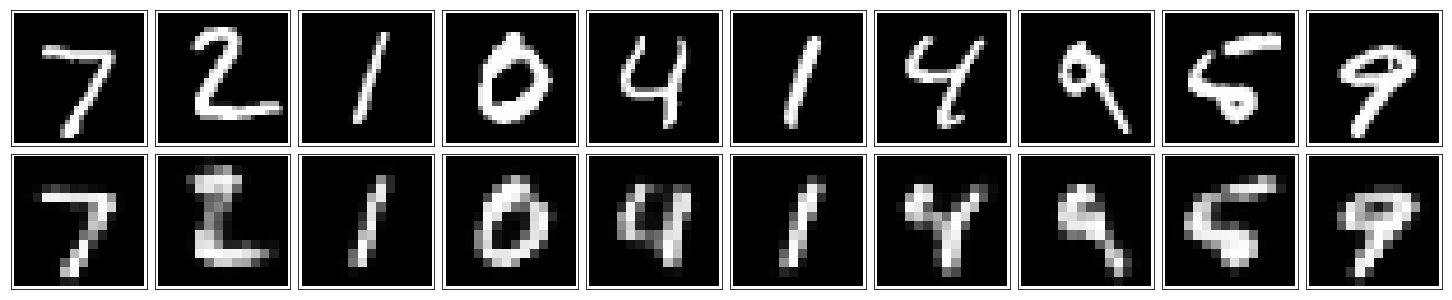

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [15]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [52]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (6,6), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), strides=(2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (6,6), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), strides=(2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (6,6), padding='same', activation=tf.nn.relu)
# Now 7x7x16
# encoded = tf.layers.max_pooling2d(conv3, (2,2), strides=(2,2), padding='same')

flat = tf.contrib.layers.flatten(conv3)
encoded = tf.layers.dense(flat, 2 ,activation=None)
# Now 4x4x16

### Decoder
upsample_pre = tf.layers.dense(encoded, 4*4*16, activation=tf.nn.relu)
upsample_pre = tf.reshape(upsample_pre, (-1,4,4,16))
upsample1 = tf.image.resize_nearest_neighbor(upsample_pre, size=(7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, size=(14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, size=(28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_,logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [53]:
sess = tf.Session()

In [54]:
epochs = 40
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.1
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/40... Training loss: 0.2117
Epoch: 2/40... Training loss: 0.2027
Epoch: 3/40... Training loss: 0.1974
Epoch: 4/40... Training loss: 0.2025
Epoch: 5/40... Training loss: 0.1996
Epoch: 6/40... Training loss: 0.1885
Epoch: 7/40... Training loss: 0.1841
Epoch: 8/40... Training loss: 0.1853
Epoch: 9/40... Training loss: 0.1886
Epoch: 10/40... Training loss: 0.1800
Epoch: 11/40... Training loss: 0.1854
Epoch: 12/40... Training loss: 0.1790
Epoch: 13/40... Training loss: 0.1821
Epoch: 14/40... Training loss: 0.1816
Epoch: 15/40... Training loss: 0.1797
Epoch: 16/40... Training loss: 0.1826
Epoch: 17/40... Training loss: 0.1806
Epoch: 18/40... Training loss: 0.1721
Epoch: 19/40... Training loss: 0.1853
Epoch: 20/40... Training loss: 0.1750
Epoch: 21/40... Training loss: 0.1752
Epoch: 22/40... Training loss: 0.1694
Epoch: 23/40... Training loss: 0.1816
Epoch: 24/40... Training loss: 0.1743
Epoch: 25/40... Training loss: 0.1711
Epoch: 26/40... Training loss: 0.1784
Epoch: 27/40... Train

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

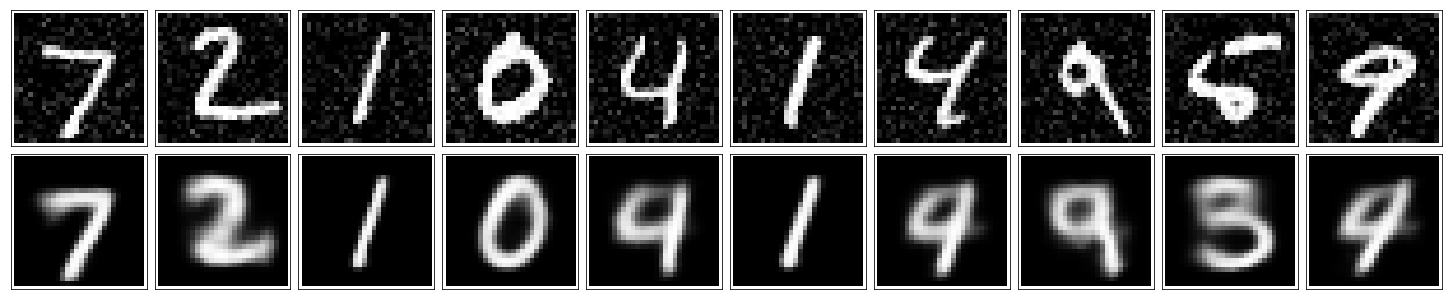

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [58]:
#check encodings
em_count = 10
in_imgs = mnist.test.images[:em_count]
encodings = sess.run(encoded, feed_dict={inputs_: in_imgs.reshape((em_count, 28, 28, 1))})

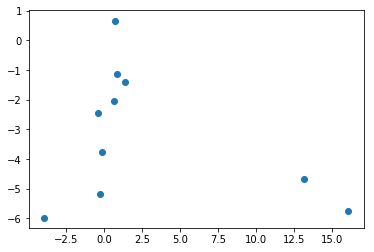

In [59]:
plt.scatter(x=encodings[:,0],y=encodings[:,1])

In [40]:
encodings[0:]

array([[  9.23634529e+00,   3.57341194e+00],
       [  1.28833258e+00,   9.66525555e-01],
       [ -1.35363072e-01,   1.11791162e+01],
       [ -3.37972581e-01,   2.22814530e-02],
       [  3.29575849e+00,  -3.65478605e-01],
       [  9.69655067e-03,   9.20221901e+00],
       [  4.34585285e+00,   4.47389066e-01],
       [  5.26521301e+00,  -1.07222986e+00],
       [  8.50448072e-01,   1.05754578e+00],
       [  3.73004580e+00,   2.18297601e+00]], dtype=float32)

In [20]:
sess.close()